In [3]:
# Setup path to import src
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils.cds_plotter import CDSPlotter

In [4]:
from src.utils import config
# Example usage with new paths:
# plotter = CDSPlotter()
# plotter.load_data('GARCH', config.OUTPUT_DIR / 'cds_spreads_garch_mc.csv')

# CDS Spread Visualization

This notebook demonstrates how to use the `CDSPlotter` class to visualize CDS spreads from different models.

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import importlib
from src.utils import cds_plotter

# Force reload to pick up changes
importlib.reload(cds_plotter)
from src.utils.cds_plotter import CDSPlotter

In [7]:
# Initialize the plotter
plotter = CDSPlotter()

# Load the data using config paths
from src.utils import config
import os

# Define file paths (matching main.ipynb outputs)
files = {
    'Merton': config.OUTPUT_DIR / 'cds_spreads_merton.csv',
    'GARCH': config.OUTPUT_DIR / 'cds_spreads_garch_mc_all_firms.csv',
    'Regime Switching': config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc_all_firms.csv',
    'MS-GARCH': config.OUTPUT_DIR / 'cds_spreads_ms_garch_mc_all_firms.csv'
}

# Load available files
for model_name, file_path in files.items():
    if file_path.exists():
        plotter.load_data(model_name, file_path)
    else:
        # Try fallback names if specific ones aren't found (for backward compatibility)
        fallback = str(file_path).replace('_all_firms', '')
        if os.path.exists(fallback):
             print(f"Loading fallback for {model_name}: {fallback}")
             plotter.load_data(model_name, fallback)
        else:
             print(f"Warning: Data for {model_name} not found at {file_path}")

Loading data for Merton from C:\Users\Chase\Downloads\Seminar QF\Seminar QF\data\output\cds_spreads_merton.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 114776 rows for Merton.


## 1. GARCH Model Results
Visualizing the term structure of CDS spreads over time for the GARCH model.

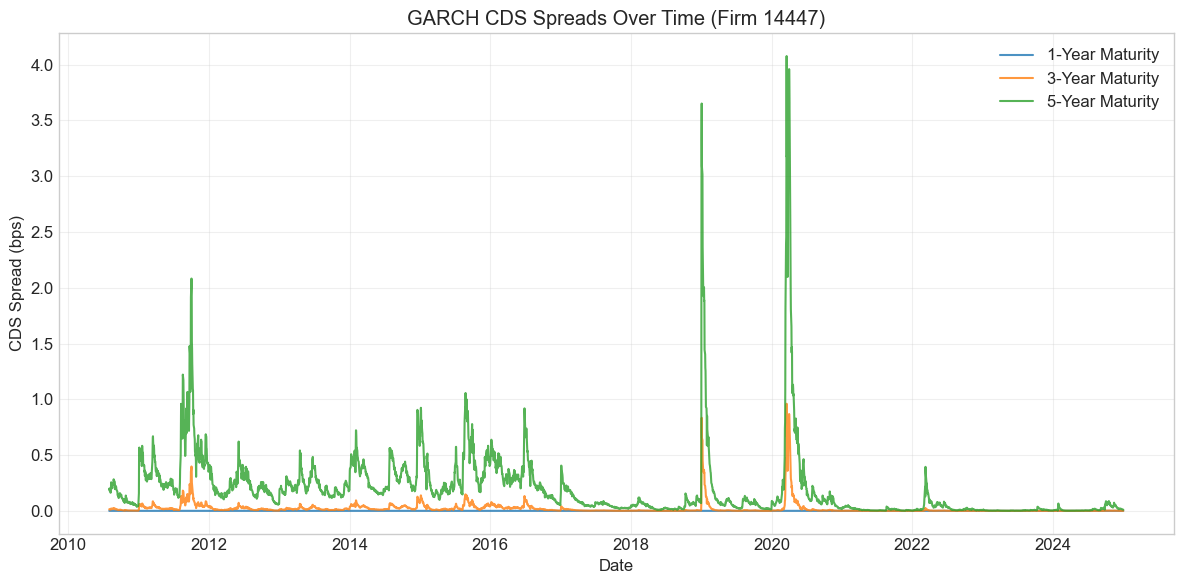

In [46]:
# Plot for firm 14447 
plotter.plot_spreads_over_time('GARCH', gvkey=14447, maturities=[1, 3, 5])

## 1.5 Merton Model Results (Analytical)
Visualizing CDS spreads from the standard Merton model.

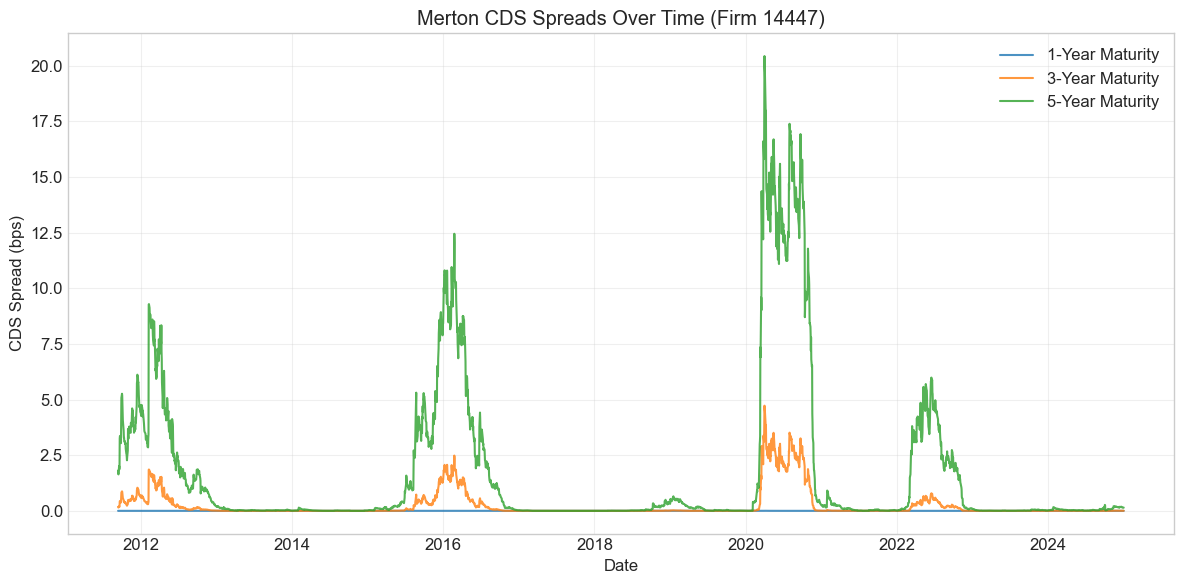

In [8]:
plotter.plot_spreads_over_time('Merton', gvkey=14447, maturities=[1, 3, 5])

## 2. Regime Switching Model Results
Visualizing the term structure of CDS spreads over time for the Regime Switching model.

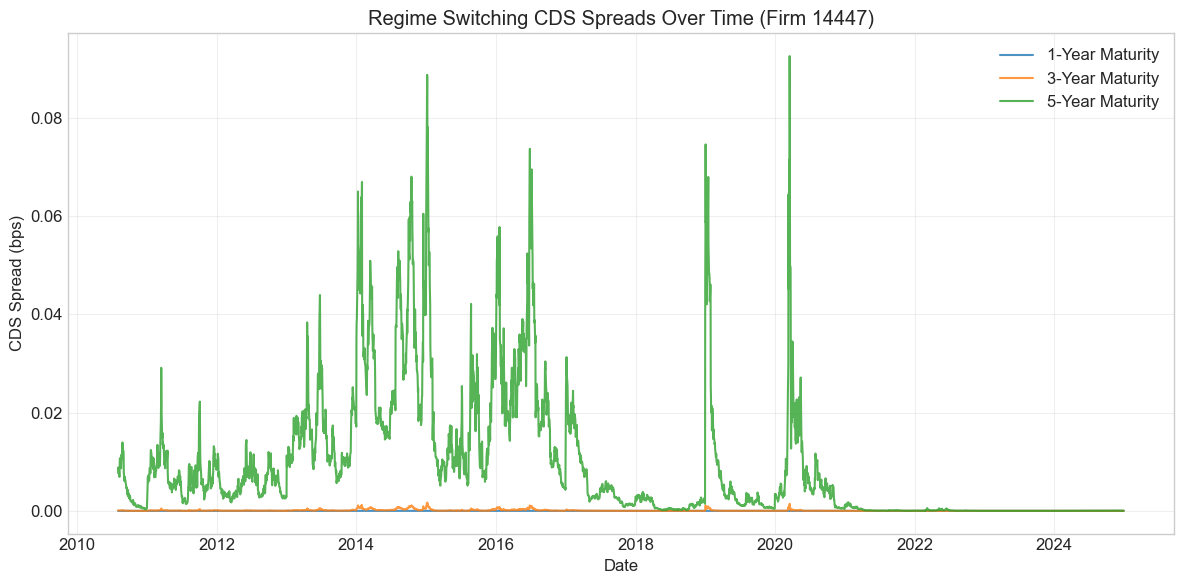

In [50]:
plotter.plot_spreads_over_time('Regime Switching', gvkey=14447, maturities=[1, 3, 5])

## 3. MS-GARCH Model Results
Visualizing the term structure of CDS spreads over time for the MS-GARCH model.

In [ ]:
plotter.plot_spreads_over_time('MS-GARCH', gvkey=14447, maturities=[1, 3, 5])

## 3. Model Comparison
Comparing the 5-year CDS spread estimates between models.

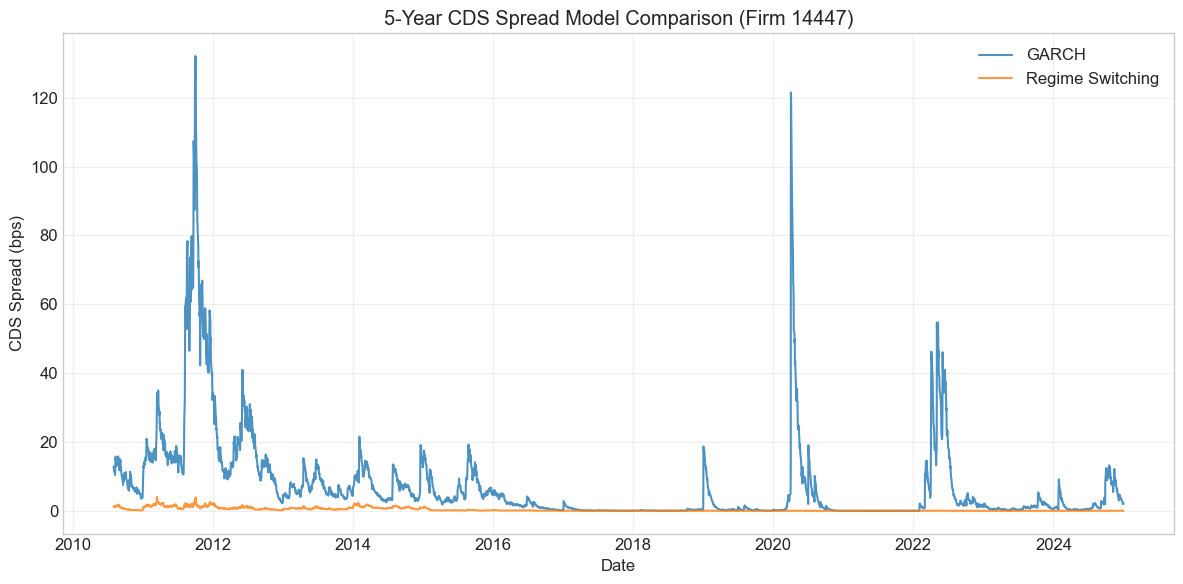

In [ ]:
# Compare all available models
available_models = [m for m in ['Merton', 'GARCH', 'Regime Switching', 'MS-GARCH'] if m in plotter.data]
print(f"Comparing models: {available_models}")
plotter.plot_model_comparison(gvkey=14447, maturity=5, models=available_models)

## 4. Average Spreads Across All Firms
Visualizing the average CDS spreads for all firms in the dataset (GARCH model).

Average Spreads: Merton


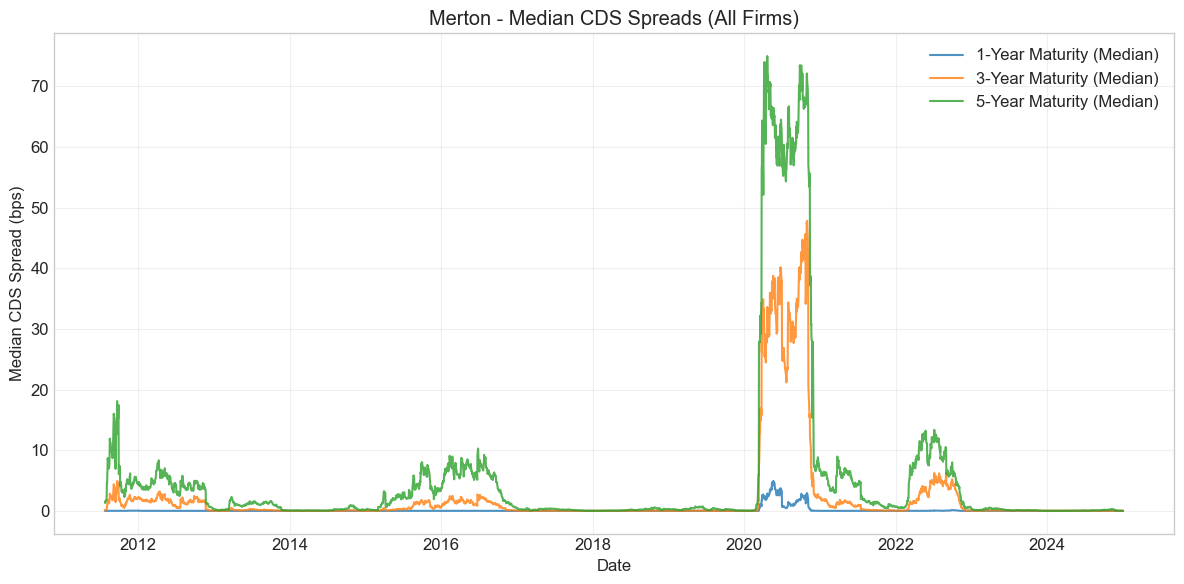

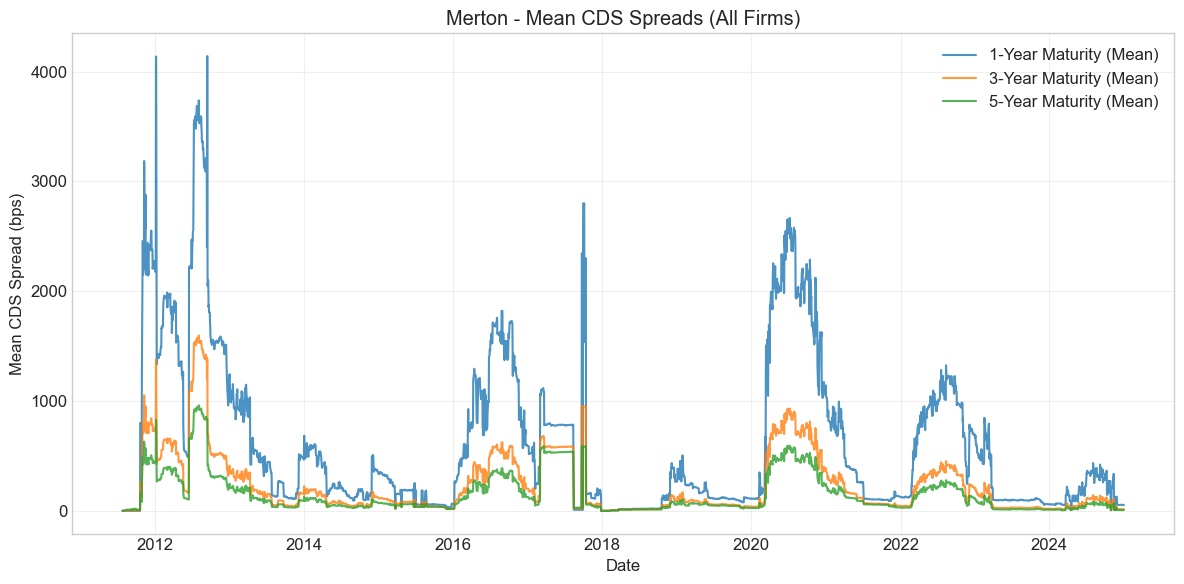

In [10]:
# Plot Average Spreads for All Models (Median and Mean of Merton)
for model in files.keys():
    if model in plotter.data:
        print(f"Average Spreads: {model}")
        
        # 1. Median (Robust to outliers)
        plotter.plot_average_spreads_over_time(model, maturities=[1, 3, 5], 
                                             aggregation='median',
                                             title=f"{model} - Median CDS Spreads (All Firms)")
        
        # 2. Mean (Only for Merton to see the difference, or all if desired)
        if model == 'Merton':
             plotter.plot_average_spreads_over_time(model, maturities=[1, 3, 5], 
                                             aggregation='mean',
                                             title=f"{model} - Mean CDS Spreads (All Firms)")